<a href="https://colab.research.google.com/github/qri0usmind/crop_price_predictor/blob/main/sameday_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# 90/10 time split
split_idx = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Lasso model
lasso = LassoCV(alphas=[0.01, 0.1, 1.0], max_iter=10000, cv=5)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# # LightGBM model
# train_data = lgb.Dataset(X_train, label=y_train)
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'learning_rate': 0.1,
#     'num_leaves': 31,
#     'max_depth': 4,
#     'verbose': -1,
#     'random_state': 42
# }
# lgb_model = lgb.train(params, train_data, num_boost_round=200)
# y_pred_lgb = lgb_model.predict(X_test)

# Combined prediction (equal weight)
y_pred_stacked = y_pred_lasso

# Evaluation
print("✅ Stacked Model (Lasso + LightGBM)")
print("MAE:", round(mean_absolute_error(y_test, y_pred_stacked), 2))
print("MSE:", round(mean_squared_error(y_test, y_pred_stacked), 2))
print("R²:", round(r2_score(y_test, y_pred_stacked), 4))


✅ Stacked Model (Lasso + LightGBM)
MAE: 7.93
MSE: 133.24
R²: 0.8641


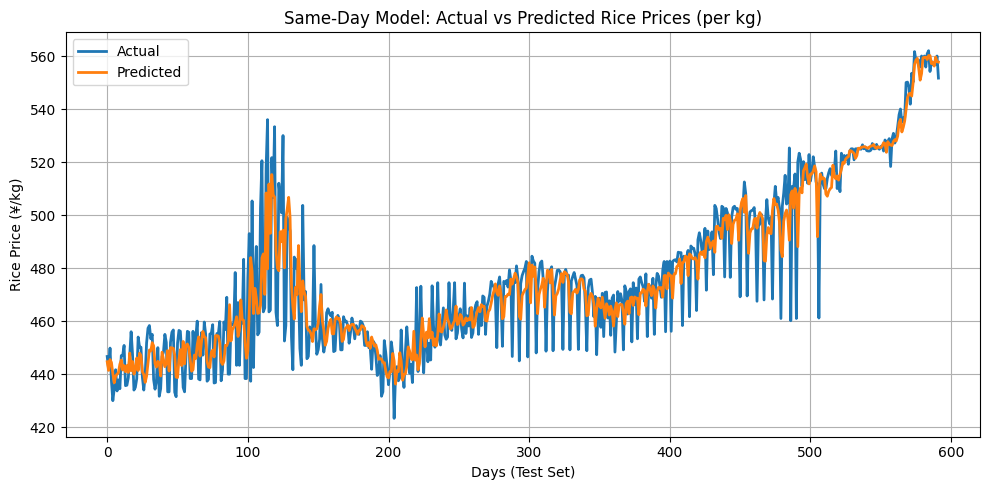

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_stacked, label='Predicted', linewidth=2)
plt.title("Same-Day Model: Actual vs Predicted Rice Prices (per kg)")
plt.xlabel("Days (Test Set)")
plt.ylabel("Rice Price (¥/kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pip install shap


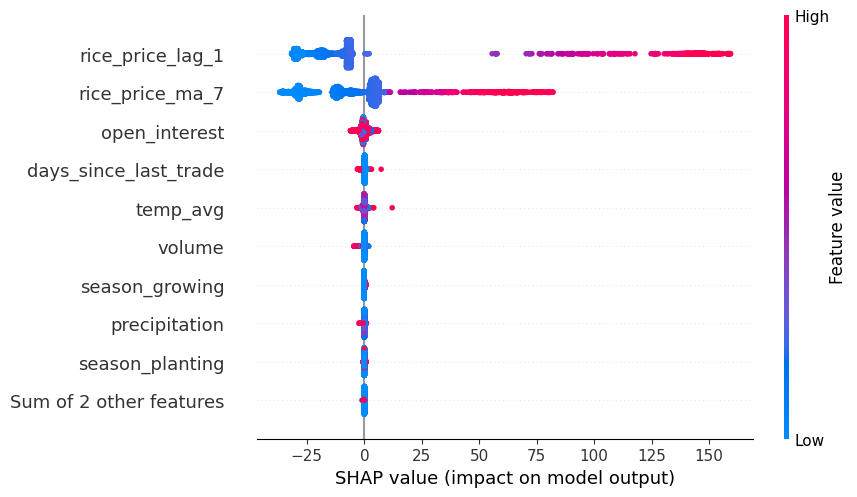

In [ ]:
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
import pandas as pd

# Load your trained LightGBM model and input data
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# Match the LightGBM training split
split_idx = int(len(X) * 0.9)
X_train = X.iloc[:split_idx]

# Fit LightGBM again (to use SHAP)
train_data = lgb.Dataset(X_train, label=y.iloc[:split_idx])
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 4,
    'verbose': -1,
    'random_state': 42
}
model = lgb.train(params, train_data, num_boost_round=200)

# Explain model with SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# === Global Summary Plot (Feature importance + direction) ===
shap.plots.beeswarm(shap_values, max_display=10)

# === Optional: Local Explanation (single observation) ===
# shap.plots.waterfall(shap_values[0])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load base dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])

# One-hot encode season
df = pd.get_dummies(df, columns=['season'])

# Select features and target
X_base = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_base)
feature_names = poly.get_feature_names_out(X_base.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)
alphas = [0.01, 0.1, 1.0, 10.0]

# Lasso with CV
lasso_model = LassoCV(alphas=alphas, cv=tscv, max_iter=10000)
lasso_model.fit(X_poly_df, y)
best_alpha = lasso_model.alpha_

# Evaluate
mae_list, mse_list, r2_list = [], [], []

for train_idx, test_idx in tscv.split(X_poly_df):
    X_train, X_test = X_poly_df.iloc[train_idx], X_poly_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LassoCV(alphas=[best_alpha], cv=tscv, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))

# Final scores
print("✅ Lasso with Polynomial Features (Same-Day)")
print("Best Alpha:", best_alpha)
print("MAE:", round(np.mean(mae_list), 2))
print("MSE:", round(np.mean(mse_list), 2))
print("R² Score:", round(np.mean(r2_list), 4))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.18118908702763, tolerance: 0.5135158468559851
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232.7700982947151, tolerance: 0.5135158468559851
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1363.5022220181254, tolerance: 0.5135158468559851
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergen

✅ Lasso with Polynomial Features (Same-Day)
Best Alpha: 1.0
MAE: 7.03
MSE: 244.23
R² Score: 0.5765


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.776e+04, tolerance: 6.947e+02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# ElasticNetCV setup
alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.2, 0.5, 0.8, 1.0]  # 1.0 = Lasso, 0.0 = Ridge
tscv = TimeSeriesSplit(n_splits=5)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=tscv, max_iter=10000)
enet_model.fit(X, y)

best_alpha = enet_model.alpha_
best_l1 = enet_model.l1_ratio_

# Evaluate model
mae_list, mse_list, r2_list = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = ElasticNetCV(alphas=[best_alpha], l1_ratio=[best_l1], cv=tscv, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))

# Print results
print("✅ ElasticNet (Same-Day)")
print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_l1)
print("MAE:", round(np.mean(mae_list), 2))
print("MSE:", round(np.mean(mse_list), 2))
print("R² Score:", round(np.mean(r2_list), 4))


✅ ElasticNet (Same-Day)
Best Alpha: 1.0
Best L1 Ratio: 0.2
MAE: 4.57
MSE: 51.81
R² Score: 0.5756
